# Bike Sharing Demand


This dataset is from the Kaggle competition [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand), originally from the [Capital Bikeshare program](https://www.capitalbikeshare.com/) - [Motivate](https://www.motivateco.com/) in Washington, D.C. 

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis.

The features related to Bikesharing in this data includes datetime, season, holiday, workingday, weather, temerature(temp), Feelslike temperature(atemp), humidity, windspeed, casual(non-registered) and registered and the Label (count) as whole bike sharing count.   

My process will be as below 

* **exploring the multiple features to define relevancy** 
* **Trying two machine learning models with chosen features and figured hyperparameter** 


## Load Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/train.csv', parse_dates = ['datetime'])
test = pd.read_csv('data/test.csv', parse_dates = ['datetime'])

print(train.shape, test.shape)
display(train.head(2), test.head(2))

(10886, 12) (6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [3]:
## datetime preprocessing

def datetime():
    train['datetime_y'] = train['datetime'].dt.year
    train['datetime_m'] = train['datetime'].dt.month
    train['datetime_d'] = train['datetime'].dt.day
    train['datetime_h'] = train['datetime'].dt.hour
    train['datetime_ym'] = pd.to_datetime(train.datetime).dt.to_period('M')

    return train

train = datetime()
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_y,datetime_m,datetime_d,datetime_h,datetime_ym
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,2011-01


## 1. Exploratory data analysis

## 1.1. Datetime

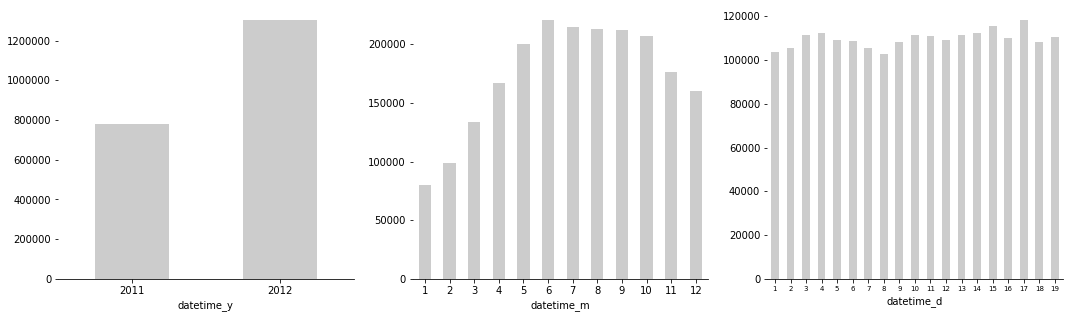

In [4]:
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows = 1, ncols = 3, figsize = (18,5))


def datechart(by, axn):
    chart = train.groupby(by)['count'].sum().plot(kind = 'bar', rot = 0, ax = axn, color = '.8')
    chart.spines['top'].set_visible(False)
    chart.spines['right'].set_visible(False)
    chart.spines['left'].set_visible(False)
    plt.xticks(fontsize = 7)

    return chart


datechart('datetime_y', ax1)
datechart('datetime_m', ax2)
datechart('datetime_d', ax3)



From this graph, we can figure out 
* **Year**: 2012 sharing count is higher than 2011, it's growing continously
* **Month**: Generally people are sharing more in the summer, but there are too much difference between January and December even though it's same winter, Will figure out more.
* **Day**: There are not many differences, and exsiting only from 1-19, since test is after that.  will be better not to use this data to avoid overfitting.
* **Hour**: We will explore more below.


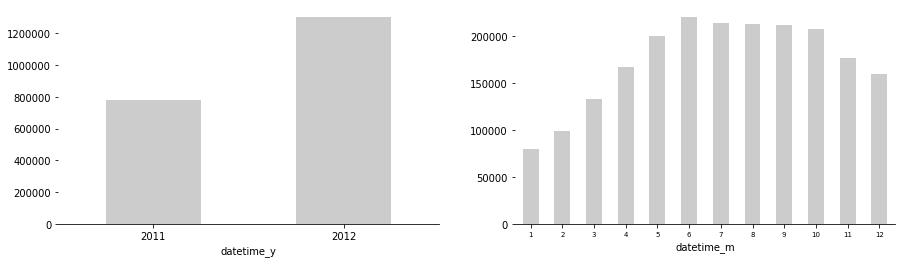

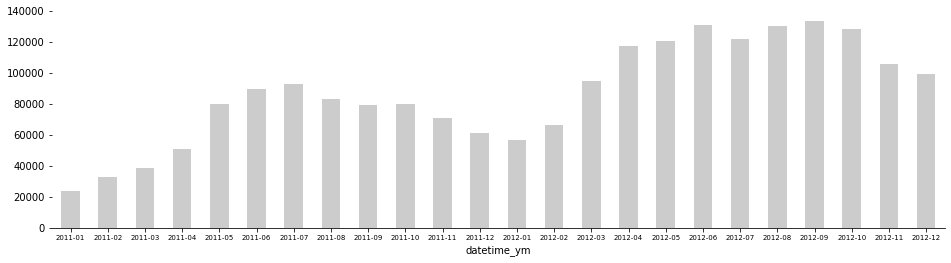

In [5]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
datechart('datetime_y', ax1)
datechart('datetime_m', ax2)


figure, ax3 = plt.subplots(figsize = (16,4))
datechart('datetime_ym', ax3)

There are difference between January in 2011 and 2012.  Therefore regarding the datetime, we will use **Year**('datetime_y'), **Year-month**('datetime_ym'), and **hour**m('datetime_h') as **feature**. 

## 1.2. Datetime _ workingday, dayofweek

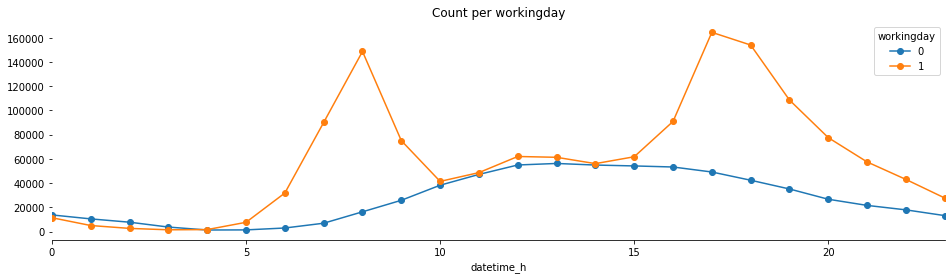

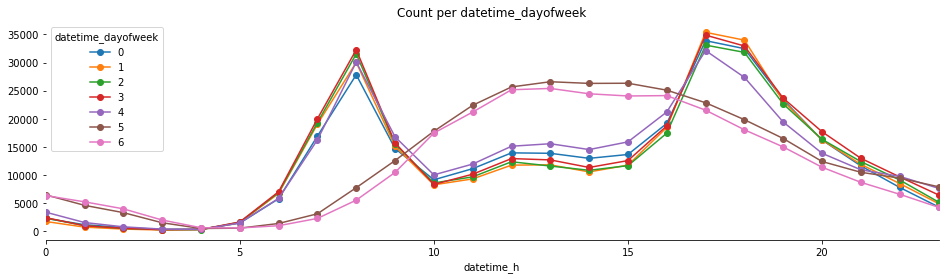

In [6]:

def datechart2(by):
    df = pd.pivot_table(data = train, index = 'datetime_h', columns = by, values = 'count', aggfunc = np.sum)
    ax = df.plot( marker = 'o', figsize = (16,4))
    ax.set_title(f'Count per {by}', fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
train['datetime_dayofweek'] = train.datetime.dt.dayofweek


datechart2('workingday')
datechart2('datetime_dayofweek')




Compare to Working day, DayofWeek shows more accurately
* Compare to Mon - Thu, count in **Friday(4) are slightly less** after 17:00.  Looks people returns to home early or have other plans before weekend.
* Additionally there are **difference between Saturday(5) and Sunday(6)** also. 
* Concluded **to use datetime_dayofweek as feature** instead of the workingday.

## 1.3. Season, Holiday

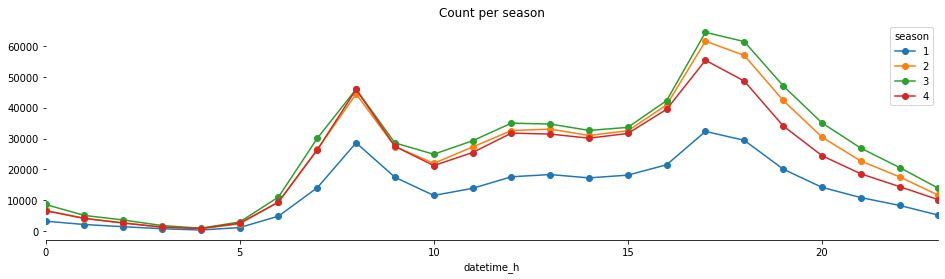

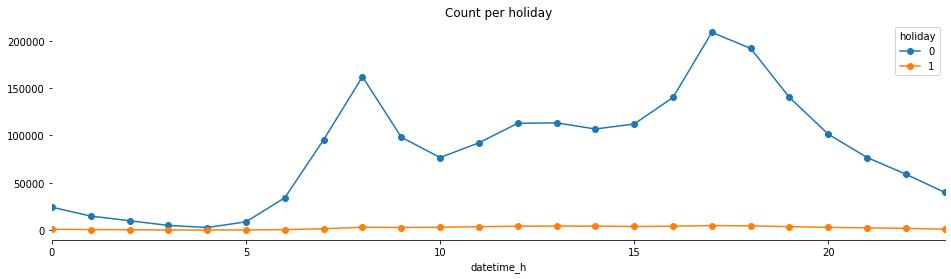

In [7]:
datechart2('season')
datechart2('holiday')


## 1.4. Weather, temperature, feelslike temperature, humidity

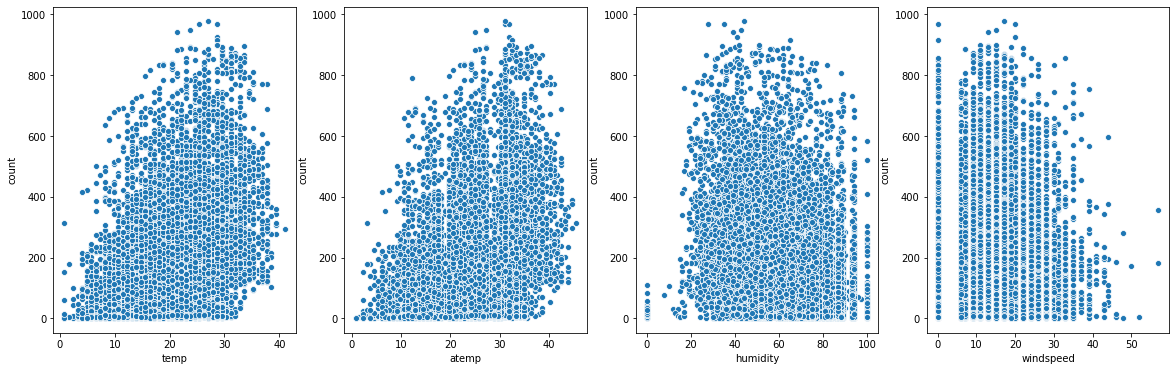

In [8]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,6))

sns.scatterplot(data = train, x = 'temp', y = 'count', estimator = np.sum, ax = ax1)
sns.scatterplot(data = train, x = 'atemp', y = 'count', estimator = np.sum, ax = ax2)
sns.scatterplot(data = train, x = 'humidity', y = 'count', estimator = np.sum, ax = ax3)
sns.scatterplot(data = train, x = 'windspeed', y = 'count', estimator = np.sum, ax = ax4)

## 1.5. Count - Label

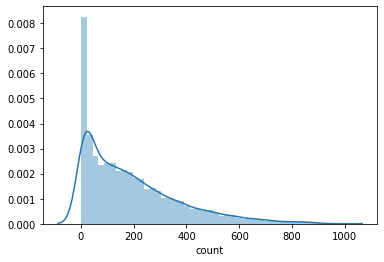

In [9]:
sns.distplot(train['count'])


* Distribution of count between 1-20 are very high.
* It reach count 1000 also,  it makes graph looks skewered, therefore will try to transform the count in log 

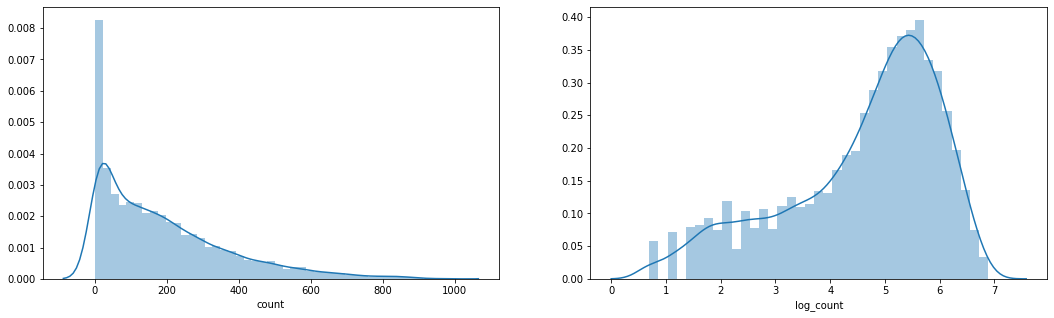

In [10]:
# Making Log transformed count

train['log_count'] = np.log(train['count'] + 1)

figure, (ax1, ax2) = plt.subplots(1,2, figsize = (18,5))

sns.distplot(train['count'], ax = ax1)
sns.distplot(train['log_count'], ax = ax2)

* The right side shows **more close to the Normal(Gaussian) Distribution**, therefore will use this log transformed count as feature
* Will add additional recovered version of the Log count for the kaggle submission. 

In [11]:
# Recovered version from Log transformed Count

train['count_exp'] = np.exp(train['log_count']) - 1
train[['count', 'log_count', 'count_exp']]

,count,log_count,count_exp
0,16,2.833213,16.0
1,40,3.713572,40.0
2,32,3.496508,32.0
3,13,2.639057,13.0
4,1,0.693147,1.0
...,...,...,...
10881,336,5.820083,336.0
10882,241,5.488938,241.0
10883,168,5.129899,168.0
10884,129,4.867534,129.0


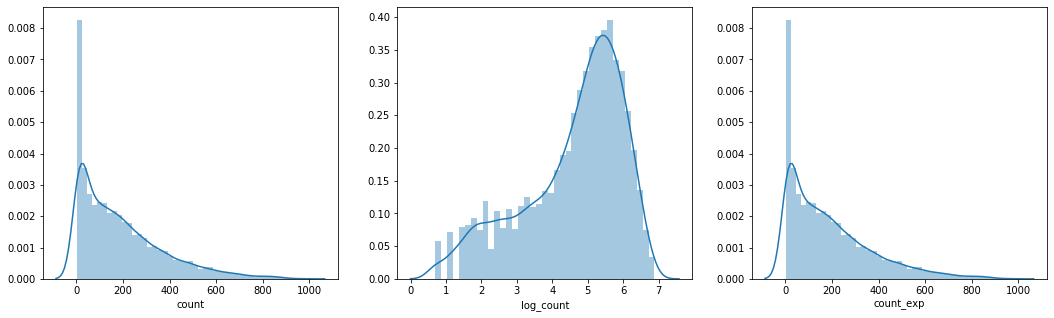

In [12]:
# Checking it recovered correctly 

figure, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,5))

sns.distplot(train['count'], ax = ax1)
sns.distplot(train['log_count'], ax = ax2)
sns.distplot(train['count_exp'], ax = ax3)

## 2. Feature Selection and Initial Evaluation 

### 2.1. Feature selection based on the EDA above

In [13]:
# Making new data based on chosen features,  train_x, train_y, and test_x

feature = ['season', 'holiday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',  
       'datetime_y','datetime_h','datetime_dayofweek']
label = 'log_count'

train_x = train[feature]
train_y = train[label]

display(train_x.head(2), train_y.head(2))
print(train_x.shape, train_y.shape)

,season,holiday,weather,temp,atemp,humidity,windspeed,datetime_y,datetime_h,datetime_dayofweek
0,1,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,1,9.02,13.635,80,0.0,2011,1,5


0    2.833213
1    3.713572
Name: log_count, dtype: float64

(10886, 10) (10886,)


In [14]:
test['datetime_y'] = test.datetime.dt.year
test['datetime_h'] = test.datetime.dt.hour
test['datetime_dayofweek'] = test.datetime.dt.dayofweek

test_x = test[feature]
print(test_x.shape)




(6493, 10)


### 2.2. Making formula for evaluation (RMSE)

* Following Kaggle competition, going to evaluate accuracy initially based on [RMSLE](https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation) before applying machine learning model.
* Already changed the **count to log_count** as above, therefore will use **```RMSE```** to score instead of **RMSLE**.


In [15]:
import numpy as np
from sklearn.metrics import make_scorer

def rmse(y_predict, y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    
    score = np.sqrt(((y_predict - y)**2).mean())
    return score

rmse_score = make_scorer(rmse)
rmse_score

make_scorer(rmse)

## 3. Modelling and submission

### 3.1. HyperParameter Tunning (max_depth, max_features) for RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

n_estimators = 300
num_epoch = 100
coarse_hyperparameters_list = [ ]

for epoch in range(num_epoch):
    max_depth = np.random.randint(low = 2, high = 100)
    max_features = np.random.uniform(low = 0.1, high = 1.0)
    
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,   
                                  random_state = 37)
    score = cross_val_score(model, train_x, train_y, cv = 20, scoring = rmse_score).mean()
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }
    
    coarse_hyperparameters_list.append(hyperparameters)
    
    if epoch % 10 == 0:
        print(f"{epoch:2}, n_estimator = {n_estimators}, max_depth = {max_depth:2}, max_feature = {max_features:2}, score = {score:.5f}")
          
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by = 'score')

print(coarse_hyperparameters_list.shape)
coarse_hyperparameters_list.head()

 0, n_estimator = 300, max_depth = 17, max_feature = 0.1395917092152753, score = 0.61097
10, n_estimator = 300, max_depth = 77, max_feature = 0.32763294372442764, score = 0.43983
20, n_estimator = 300, max_depth = 59, max_feature = 0.4980439751868957, score = 0.39818
30, n_estimator = 300, max_depth = 12, max_feature = 0.5099251622663861, score = 0.39794
40, n_estimator = 300, max_depth = 78, max_feature = 0.8437111565209913, score = 0.35639
50, n_estimator = 300, max_depth = 97, max_feature = 0.9745535686926634, score = 0.35659
60, n_estimator = 300, max_depth = 41, max_feature = 0.5478748589631158, score = 0.37625
70, n_estimator = 300, max_depth = 54, max_feature = 0.8091958292753868, score = 0.35639
80, n_estimator = 300, max_depth =  3, max_feature = 0.433551939978288, score = 0.79667
90, n_estimator = 300, max_depth = 15, max_feature = 0.2897043952732131, score = 0.52142
(100, 5)


,epoch,score,n_estimators,max_depth,max_features
53,53,0.356380,300,35,0.867085
75,75,0.356389,300,46,0.898691
15,15,0.356389,300,73,0.845783
72,72,0.356389,300,83,0.877097
70,70,0.356389,300,54,0.809196


### 3.2. Running RandomForestRegressor with parameter

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 3000,
                              max_depth = 35,
                              max_features = 0.867085,
                              random_state = 37,
                              n_jobs = -1
                             )
model.fit(train_x, train_y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=0.979024, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3000,
                      n_jobs=-1, oob_score=False, random_state=37, verbose=0,
                      warm_start=False)

In [18]:
log_predictions = model.predict(test_x)
predictions = np.exp(log_predictions) - 1
print(log_predictions.shape, predictions.shape)
print(log_predictions, predictions)


(6493,) (6493,)
[2.48688406 1.72431018 1.39673694 ... 4.55506758 4.58804343 3.86115208] [11.02375235  4.60865071  3.04198917 ... 94.11318264 97.30190753
 46.52006674]


In [19]:
## Kaggle Score: 0.39962 Rank 224/3242

submission = pd.DataFrame({'datetime': test['datetime'], 'count': predictions})
submission.to_csv('submission1.csv', index = False)

### 3.2. Running GradientBoostingRegressor

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

model2 = GradientBoostingRegressor(n_estimators = 3000, random_state = 0)
model2.fit(train_x, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [21]:
log_predictions2 = model2.predict(test_x)
predictions2 = np.exp(log_predictions2) -1
print(log_predictions2.shape, predictions2.shape)
print(log_predictions2, predictions2)


(6493,) (6493,)
[2.45516122 1.7129581  1.2938031  ... 4.66451375 4.37971706 3.67784703] [ 10.64831133   4.54534092   2.6466287  ... 105.11397526  78.81544711
  38.56112833]


In [22]:
## Kaggle Score: 0.37848  Rank 102/3242

submission2 = pd.DataFrame({'datetime': test['datetime'], 'count': predictions2})
submission2.to_csv('submission2.csv', index = False)